In [10]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import lightgbm as lgb

In [11]:
# Critere de performance
def compute_pred_score(y_true, y_pred):
    y_pred_unq = np.unique(y_pred)
    for i in y_pred_unq:
        if (i != -1) & (i!= 1) & (i!= 0):
            raise ValueError('The predictions can contain only -1, 1, or 0!')
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score

def uncerAjust(y_pred, y_pred_pro, number=300):
    temps = y_pred
    abs = np.abs(y_pred_pro[:, 1]-y_pred_pro[:, 0])
    index = np.argpartition(abs, number)[:number]
    temps[index] = 0
    return temps

def uncerAjustPro(y_pred, y_pred_pro, threshold=0.9):
    temps = y_pred
    for i in xrange(len(y_pred)):
        if y_pred_pro[i][1] < threshold and y_pred_pro[i][0] < threshold:
            temps[i] = 0
    return temps

def scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    y_pred_pro = estimator.predict_proba(X)
    y_pred = uncerAjust(y_pred, y_pred_pro)
    return 1-compute_pred_score(y, y_pred)

In [12]:
X_train_fname = 'training_templates.csv'
y_train_fname = 'training_labels.txt'
X_test_fname = 'testing_templates.csv'
X_train = pd.read_csv(X_train_fname, sep=',', header=None).values
X_test = pd.read_csv(X_test_fname,  sep=',', header=None).values
y_train = np.loadtxt(y_train_fname, dtype=np.int)

In [13]:
train_set=lgb.Dataset(X_train, label=y_train)
params = {
    'metric': {'l1', 'l2'},
    'num_leaves': 300,
    'verbose': 0
}

gbm = lgb.train(params,
                train_set,
                num_boost_round=100)
fip = gbm.feature_importance()
n_feature = 118
index_lgb = np.argsort(fip)[128-n_feature:]
X_lgb = X_train[:, index_lgb]
X_test_lgb = X_test[:, index_lgb]
print X_lgb.shape, X_test_lgb.shape

(105600, 118) (8496, 118)


In [14]:
print index_lgb[::-1]

[ 79  19   1  44  25  23  96  77 102   6 108  69  40 105  30  86  75 116
  42  74  52  87  53  27  36 121  76   7  57  33  34  84 122  41  67  11
  14  18 101 103 125  73  24  65 106  46 109  50  56  20  71  78  64  16
  92  60  98  48  95 126  94 119  68  93  59  13  12  58  49  99  37  17
 127   5 118 120  38  32   9  91 115  21  83 123 110  88  97   8  31  15
 114  22 100  63 112  54  55  70   2  51  81 104 124  61  90  43  85   0
  10  28 113 111  62  35   3  26  80  45]


In [15]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X_lgb)
distances, indices = nbrs.kneighbors(X_test_lgb)
index_knn = np.ravel(indices)

In [16]:
print index.shape
index_unique = np.unique(index_knn)
X_knn = X_lgb[index_unique]
y_knn = y_train[index_unique]
print X_knn.shape, y_knn.shape

(84960,)
(40442, 118) (40442,)


In [17]:
# IndexPX = [ 79,19,25 ,108 ,116  ,77  ,86   ,6 ,105  ,34  ,87 ,102  ,67  , 7  ,52 , 69,101  , 1
#   ,53 , 78 , 57 , 74 , 44  ,20 ,122, 121, 103 , 41 , 75,  33,  76,  65,  71 , 40 , 11 , 50,
#  126 , 68 , 30  ,49 , 93 , 18 ,125  ,42,  64 , 16 , 92 , 14 , 98, 109, 106 , 60, 120,  32
#   ,24 , 13 , 59 , 73  ,84, 118,  96 , 38 , 54 , 23 ,123 , 48  ,46  ,36 , 94,  70,  31,  83,
#   56 ,58 , 51 ,  9 , 91 , 55 ,113 ,115 ,112 , 37, 110 ,119 , 99  ,47  ,17  ,12  ,35 ,114,
#   26 , 15 , 61 ,104  ,27, 124 , 22,  81 , 85 , 62 , 88 ,  2 , 95 , 97 , 10, 111 ,  0 ,  5
#   , 3, 127 , 21 , 29, 117, 107 , 45 , 66 , 90]

In [18]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_knn, y_knn,
                                                            train_size=0.95, test_size=0.05, random_state=42)

In [19]:
pca = PCA(svd_solver='randomized', n_components=n_feature, whiten=True)
X_train_pca = pca.fit_transform(X_train_1)
print 1

alpha = 3
size_mlp = y_train_1.shape[0]/(alpha*(2+n_feature))
print size_mlp
clf = BaggingClassifier(MLPClassifier(hidden_layer_sizes=(size_mlp, size_mlp, size_mlp, size_mlp)),
                        n_estimators=50, max_features=0.7, max_samples=0.7, n_jobs=-1)
clf.fit(X_train_pca, y_train_1)

1
106


BaggingClassifier(base_estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(106, 106, 106, 106), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.7,
         max_samples=0.7, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

thre:123.000000
score:0.085517


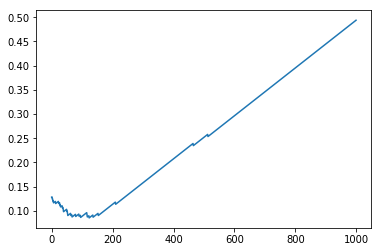

In [20]:
threshold = 0
X_test_pca = pca.transform(X_test_1)
y_pred = clf.predict(X_test_pca)
y_pred_pro = clf.predict_proba(X_test_pca)

score = 1
scores = []
for i in np.arange(0, 1000):
    y_pred_1 = uncerAjust(y_pred, y_pred_pro, i)
    temp = compute_pred_score(y_pred_1, y_test_1)
    scores.append(temp)
    if temp < score:
        score = temp
        threshold = i
print 'thre:%f' %threshold
print 'score:%f' %score
plt.plot(scores)
plt.show()

In [27]:
X_test_pca1 = pca.transform(X_test_lgb)
y_pred = clf.predict(X_test_pca1)
y_pred_pro = clf.predict_proba(X_test_pca1)
y_pred = uncerAjust(y_pred, y_pred_pro, 425)
print list(y_pred).count(0)
np.savetxt('y_pred_bagg.txt', y_pred, fmt='%d')

425
